In [0]:
%config IPCompleter.greedy=True

In [64]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import keras
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

1.15.2
2.3.1


In [0]:
def load_dataset(flatten=False):
  (X_train,y_train),(X_test,y_test)=keras.datasets.mnist.load_data()
  X_train=X_train.astype(float)/255.
  X_test=X_test.astype(float)/255.
  X_train,X_val=X_train[:10000],X_train[-10000:]
  y_train,y_val=y_train[:10000],y_train[-10000:]
  if flatten:
    X_train=X_train.reshape([X_train.shape[0],-1])
    X_val=X_val.reshape([X_val.shape[0],-1])
    X_test=X_test.reshape([X_test.shape[0],-1])
  return X_train,y_train,X_val,y_val,X_test,y_test

def load_dataset_from_file(flatten=False):
  (X_train,y_train),(X_test,y_test)=load_data()
  X_train=X_train.astype(float)/255.
  X_test=X_test.astype(float)/255.
  X_train,X_val=X_train[:-10000],X_train[-10000:]
  y_train,y_val=y_train[:-10000],y_train[-10000:]
  if flatten:
    X_train=X_train.reshape([X_train[0],-1])
    X_val=X_val.reshape([X_val.shape[0],-1])
    X_test=X_test.reshape([X_test.shape[0],-1])
  return X_train,y_train,X_test,y_test,X_val,y_val

def load_data(path='mnist.npz'):
  with np.load(path) as f:
    x_train,y_train=f['x_train'],f['y_train']
    x_test,y_test=f['x_test'],f['y_test']
  return (x_train,y_train),(x_test,y_test)

In [0]:
X_train,y_train,X_val,y_val,X_test,y_test=load_dataset_from_file()

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


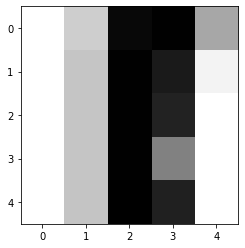

And the whole sample


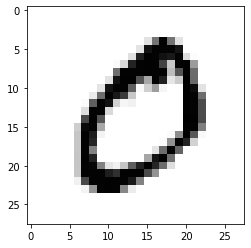

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [67]:
print('X_train [shape %s] sample patch:\n'%
      str(X_train.shape),X_train[1,15:20,5:10])
print('A closeup of a sample patch:')
plt.imshow(X_train[1,15:20,5:10],cmap='Greys')
plt.show()
print('And the whole sample')
plt.imshow(X_train[1],cmap='Greys')
plt.show()
print('y_train [shape %s] 10 samples:\n'%
      (str(y_train.shape)),y_train[:10])

In [68]:
X_train_flat=X_train.reshape((X_train.shape[0],-1))
print(X_train_flat.shape)
X_val_flat=X_val.reshape((X_val.shape[0],-1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [69]:
y_train_oh=keras.utils.to_categorical(y_train,10)
y_val_oh=keras.utils.to_categorical(y_val,10)
print(y_train_oh.shape)
print(y_train_oh[:3],y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [0]:
from keras import backend as K

def reset_tf_session():
  curr_session=tf.get_default_session()
  if curr_session is not None:
    curr_session.close()
  K.clear_session()
  config=tf.ConfigProto()
  config.gpu_options.allow_growth=True
  s=tf.InteractiveSession(config=config)
  K.set_session(s)
  return s

In [0]:
from keras.layers import Dense,Activation
from keras.models import Sequential

s=reset_tf_session()

model=Sequential()
model.add(Dense(256,input_shape=(784,)))
model.add(Activation('sigmoid'))
model.add(Dense(256))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
________________________________________________

In [0]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [0]:
import tqdm
tqdm.monitor_interval=0
class SimpleTqdm():

  def __init__(self,iterable=None,total=None,**kwargs):
    self.iterable=list(iterable) if iterable is not None else None
    self.total=len(self.iterable) if self.iterable is not None else total
    assert self.iterable is not None or self.total is not None
    self.current_step=0
    self.print_frequency=max(self.total//50,1)

  def set_description_str(self,desc):
    self.desc=desc

  def set_description(self,desc):
    self.desc=desc

  def update(self,steps):
    last_print_step=(self.current_step//self.print_frequency)*\
    self.print_frequency
    i=1
    while (last_print_step+i*self.print_frequency<=
           self.current_step+steps):
      print('*',end='')
    self.current_step+=steps

  def close(self):
    print('\n'+self.desc)
  def __iter__(self):

    assert self.iterable is not None
    self.index=0
    return self  

  def __next__(self):
    if self.index<self.total:
      element=self.iterable[self.index]
      self.update(1)
      self.index+=1
      return element
    else:
      self.close()
      raise StopIteration

def tqdm_notebook_failsafe(*args,**kwargs):
  try:
    return tqdm.notebook.tqdm(*args,**kwargs)
    print('using normal tqdm')
  except:
    print('using custom tqdm')
    return SimpleTqdm(*args,**kwargs)

In [0]:
from collections import defaultdict
class TqdmProgressCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs=None):
    self.epochs=self.params['epochs']

  def on_epoch_begin(self,epoch,logs=None):
    print('\nEpoch %d/%d'%(epoch+1,self.epochs))
    if 'steps' in self.params:
      self.use_steps=True
      self.target=self.params['steps']
    else:
      self.use_steps=False
      self.target=self.params['samples']
    self.prog_bar=tqdm_notebook_failsafe(total=self.target)
    self.log_values_by_metric=defaultdict(list)

  def _set_prog_bar_desc(self,logs):
    for k in self.params['metrics']:
      if k in logs:
        self.log_values_by_metric[k].append(logs[k])
    desc=';'.join('{0}: {1:.4f}'.format(k,np.mean(values)) for
                  k,values in self.log_values_by_metric.items())
    if hasattr(self.prog_bar,'set_description_str'):
      self.prog_bar.set_description_str(desc)
    else:
      self.prog_bar.set_description(desc)

  def on_batch_end(self,batch,logs=None):
    logs=logs or {}
    if self.use_steps:
      self.prog_bar.update(1)
    else:
      batch_size=logs.get('size',0)
      self.prog_bar.update(batch_sizes)
    self._set_prog_bar_desc(logs)

  def on_epoch_end(self,epoch,logs=None):
    logs=logs or {}
    self._set_prog_bar_desc(logs)
    self.prog_bar.update(1)
    self.prog_bar.close()

In [97]:
model.fit(
    X_train_flat,
    y_train_oh,
    batch_size=512,
    epochs=10,
    validation_data=(X_val_flat,y_val_oh),
    callbacks=[TqdmProgressCallback()],
    verbose=0
)


Epoch 1/10




Epoch 2/10




Epoch 3/10




Epoch 4/10




Epoch 5/10




Epoch 6/10




Epoch 7/10




Epoch 8/10




Epoch 9/10




Epoch 10/10
